## Import Dependencies

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

## Load and Explore Data

In [22]:
import pickle

# Load the pickle file
with open('data/train_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images = data['images']
labels = data['labels']

In [23]:
print(images[0,:,:,:])

[[[ 6  4  0]
  [ 9  5  0]
  [ 8  4  0]
  ...
  [ 9  6  0]
  [ 9  6  0]
  [ 7  4  0]]

 [[11  6  0]
  [ 4  4  0]
  [ 3  3  0]
  ...
  [ 9  6  0]
  [ 6  4  0]
  [ 4  2  0]]

 [[11  6  0]
  [ 4  4  0]
  [ 3  3  0]
  ...
  [ 6  4  0]
  [ 6  4  0]
  [ 4  2  0]]

 ...

 [[ 1  1  0]
  [ 0  0  0]
  [ 0  0  1]
  ...
  [ 5  4  0]
  [ 6  5  0]
  [ 6  5  0]]

 [[ 3  1  1]
  [ 0  0  0]
  [ 0  0  1]
  ...
  [ 6  5  0]
  [ 6  5  0]
  [ 7  6  0]]

 [[10  2  2]
  [ 0  0  1]
  [ 0  0  1]
  ...
  [ 6  5  0]
  [ 7  6  0]
  [ 7  6  0]]]


In [24]:
import numpy as np
np.unique(labels)

array([0, 1, 2, 3, 4], dtype=uint8)

In [180]:
class ShallowNN:
    def __init__(self, input_size, hidden_size, output_size, random_seed=42):
        """

        :param input_size: Number of features
        :param hidden_size: Number of neurons in the hidden layer
        :param output_size: Number of neurons in the output layer.
        Initialize weights and biases for a 1-hidden layer neural network
        :
        """
        np.random.seed(random_seed)
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((output_size, 1))

        std_dev = np.sqrt(1 / input_size)
        self.W1 = np.random.randn(hidden_size, input_size) * std_dev

        std_dev_2 = np.sqrt(1 / hidden_size)
        self.W2 = np.random.randn(output_size, hidden_size) * std_dev_2
    def _relu(self, Z):
        return np.maximum(0, Z)  # ReLU activation for the Hidden Layer
    def _softmax(self, Z):
        """Softmax activation for the Output Layer."""
        # Ensure numerical stability by subtracting max(Z)
        exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    def _relu_derivative(self, A):
        return (A > 0).astype(int)
    def forward_propagate(self, X):
        #Input X must be transposed: (D, M) -> (Features, Samples)
        ### 1st matrix multiplication
        ### Z1 = W1*X + b1 -> then apply activation function
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self._relu(self.Z1)
        ### 2nd matrix multiplication
        ### Z2 = W2*LastOutput+ b2 -> then apply activation function
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self._softmax(self.Z2)
        return self.A2
    def back_propagate(self, X, Y, learning_rate):
        """Performs the backward pass and updates weights/biases."""
        m = X.shape[1]  # number of samples

        #1. Calculate output layer error
        dZ2 = self.A2 - Y  # Assuming Y is one-hot encoded

        #2. Calculate gradients for W2 and b2
        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

        #3. Calculate hidden layer error
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self._relu_derivative(self.A1)

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        # 5. Update Weights and Biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
    def _calculate_loss(self, Y_true, Y_hat):
        """Calculates the cross-entropy loss."""
        m = Y_true.shape[1]
        loss = -np.sum(Y_true * np.log(Y_hat + 1e-9)) / m
        return loss

    def train(self, X_train, Y_train, X_valid, Y_valid, epochs=1000, learning_rate=0.01, log_interval=10):
        """Trains the neural network using the provided training data."""
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            # Forward propagation
            Y_hat_train = self.forward_propagate(X_train)
            # Backward propagation
            self.back_propagate(X_train, Y_train, learning_rate)

            if epoch % log_interval == 0 or epoch == 1:
                train_loss = self._calculate_loss(Y_train, Y_hat_train)
                train_loss_history.append(train_loss)

                Y_hat_valid = self.forward_propagate(X_valid)
                valid_loss = self._calculate_loss(Y_valid, Y_hat_valid)
                valid_loss_history.append(valid_loss)
                #print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                print(f"Epoch {epoch:<4}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")
        return train_loss_history, valid_loss_history
    def predict(self, X):
        """Generates binary predictions (0 or 1)."""
        probs = self.forward_propagate(X)
        return np.argmax(probs, axis=0) # argmax along the output unit dimension


In [374]:
def one_hot_encode(Y_sparse, num_classes): #we have 5 classes: 0,1,2,3,4
    """
    Converts a sparse label vector (Y_sparse) into a one-hot encoded matrix.

    :param Y_sparse: 1D array of integer labels (e.g., [0, 1, 2, 0])
    :param num_classes: Total number of unique classes (K)
    :return: 2D NumPy array in shape (K, M) for the WX convention
    """
    # 1. Create the identity matrix (K, K)
    # The identity matrix (np.eye(K)) acts as a lookup table.
    # np.eye(3) -> [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # 2. Use sparse labels as indices
    # This selects the appropriate row from the identity matrix for each label.
    one_hot_matrix = np.eye(num_classes)[Y_sparse] # Shape: (M, K)

    # 3. Transpose for the WX convention
    # Convert (Samples, Classes) to (Classes, Samples) -> (K, M)
    return one_hot_matrix.T

In [375]:
# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_gray = np.dot(images[..., :3], rgb_weights)



images_flattened = images_gray.reshape(images_gray.shape[0], -1)
images_normalized = images_flattened / 255.0
labels_encoded = one_hot_encode(labels.flatten(), num_classes=5)
X = (images_normalized).T  # Shape: (Features, Samples)
Y = labels_encoded       # Shape: (Classes, Samples)
Y

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(5, 1080))

In [376]:
def train_val_split(X, Y, val_ratio=0.2, random_seed=42):
    """
    Splits transposed X (Features, Samples) and Y (Classes, Samples)
    into training and validation sets.
    """
    # 1. Set the random seed for reproducibility
    np.random.seed(random_seed)

    # 2. Determine the number of samples (M)
    # Since X is (Features, Samples), M is the second dimension (axis 1)
    M = X.shape[1]

    # 3. Create a shuffled array of indices from 0 to M-1
    indices = np.arange(M)
    np.random.shuffle(indices)

    # 4. Calculate the split point
    val_size = int(M * val_ratio)

    # 5. Define the split indices
    val_indices = indices[:val_size]
    train_indices = indices[val_size:]

    # 6. Split the data arrays (using advanced indexing on the Samples axis)
    # The indices array is used to select the columns (samples) in the desired order
    X_train = X[:, train_indices]
    Y_train = Y[:, train_indices]

    X_val = X[:, val_indices]
    Y_val = Y[:, val_indices]

    return X_train, X_val, Y_train, Y_val
X_train, X_val, Y_train, Y_val = train_val_split(
    X,
    Y,
    val_ratio=0.2,
    random_seed=42
)

## Train Models

Train and compare multiple machine learning models.

In [377]:
class DeepNN: #we will try 28x28 layers, with relu for each activation except the last layer which will be softmax
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size, random_seed=42):
        """

        :param input_size: Number of features
        :param hidden_size: Number of neurons in the hidden layer
        :param output_size: Number of neurons in the output layer.
        Initialize weights and biases for a 1-hidden layer neural network
        :
        """
        np.random.seed(random_seed)
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((hidden_size_2, 1))
        self.b3 = np.zeros((output_size, 1))

        std_dev = np.sqrt(1 / input_size)
        self.W1 = np.random.randn(hidden_size, input_size) * std_dev

        std_dev_2 = np.sqrt(1 / hidden_size)
        self.W2 = np.random.randn(hidden_size_2, hidden_size) * std_dev_2

        std_dev_3 = np.sqrt(1 / hidden_size_2)
        self.W3 = np.random.randn(output_size, hidden_size_2) * std_dev_3

    def _relu(self, Z):
        return np.maximum(0, Z)  # ReLU activation for the Hidden Layer
    def _softmax(self, Z):
        """Softmax activation for the Output Layer."""
        # Ensure numerical stability by subtracting max(Z)
        exp_z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)
    def _relu_derivative(self, A):
        return (A > 0).astype(int)
    def forward_propagate(self, X):
        #Input X must be transposed: (D, M) -> (Features, Samples)
        ### 1st matrix multiplication
        ### Z1 = W1*X + b1 -> then apply activation function
        self.Z1 = np.dot(self.W1, X) + self.b1
        self.A1 = self._relu(self.Z1)
        ### 2nd matrix multiplication
        ### Z2 = W2*LastOutput+ b2 -> then apply activation function
        self.Z2 = np.dot(self.W2, self.A1) + self.b2
        self.A2 = self._relu(self.Z2)

        self.Z3 = np.dot(self.W3, self.A2) + self.b3
        self.A3 = self._softmax(self.Z3)

        return self.A3
    def back_propagate(self, X, Y, learning_rate):
        """Performs the backward pass and updates weights/biases."""
        m = X.shape[1]  # number of samples

        #1. Calculate output layer error

        dZ3 = self.A3 - Y
        dW3 = (1 / m) * np.dot(dZ3, self.A2.T)
        db3 = (1 / m) * np.sum(dZ3, axis=1, keepdims=True)

        dA2 = np.dot(self.W3.T, dZ3)
        dZ2 = dA2 * self._relu_derivative(self.A2)

        dW2 = (1 / m) * np.dot(dZ2, self.A1.T)
        db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)



        #3. Calculate hidden layer error
        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * self._relu_derivative(self.A1)

        dW1 = (1 / m) * np.dot(dZ1, X.T)
        db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

        # 5. Update Weights and Biases
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W3 -= learning_rate * dW3
        self.b3 -= learning_rate * db3
    def _calculate_loss(self, Y_true, Y_hat):
        """Calculates the cross-entropy loss."""
        m = Y_true.shape[1]
        loss = -np.sum(Y_true * np.log(Y_hat + 1e-9)) / m
        return loss

    def train(self, X_train, Y_train, X_valid, Y_valid, epochs=1000, learning_rate=0.01, log_interval=10):
        """Trains the neural network using the provided training data."""
        train_loss_history = []
        valid_loss_history = []
        for epoch in range(epochs):
            if epoch > 0 and epoch % 500 == 0:
                learning_rate *= 0.5
                print(f"Epoch {epoch}: LR decayed to {learning_rate:.5f}")
            # Forward propagation
            Y_hat_train = self.forward_propagate(X_train)
            # Backward propagation
            self.back_propagate(X_train, Y_train, learning_rate)

            if epoch % log_interval == 0 or epoch == 1:
                train_loss = self._calculate_loss(Y_train, Y_hat_train)
                train_loss_history.append(train_loss)

                Y_hat_valid = self.forward_propagate(X_valid)
                valid_loss = self._calculate_loss(Y_valid, Y_hat_valid)
                valid_loss_history.append(valid_loss)
                #print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
                print(f"Epoch {epoch:<4}, Train Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")
        return train_loss_history, valid_loss_history
    def predict(self, X):
        """Generates binary predictions (0 or 1)."""
        probs = self.forward_propagate(X)
        return np.argmax(probs, axis=0) # argmax along the output unit dimension


In [379]:
def soft_oversample(X, Y):
    """
    Duplicates specific classes to boost their signal without
    creating a perfectly balanced (and unrealistic) dataset.
    """
    # Convert to sparse to identify classes
    labels = np.argmax(Y, axis=0)

    # Start with the original data
    X_list = [X]
    Y_list = [Y]

    # --- STRATEGY: Manual Boost ---

    # Class 4 (Rare): Boost 3x total (Original + 2 copies)
    idx_4 = np.where(labels == 4)[0]
    # Copy 1
    X_list.append(X[:, idx_4])
    Y_list.append(Y[:, idx_4]) # <--- WAS MISSING
    # Copy 2
    X_list.append(X[:, idx_4])
    Y_list.append(Y[:, idx_4]) # <--- WAS MISSING

    # Class 1 (Uncommon): Boost 2x total (Original + 1 copy)
    idx_1 = np.where(labels == 1)[0]
    X_list.append(X[:, idx_1])
    Y_list.append(Y[:, idx_1]) # <--- WAS MISSING

    # Class 2 (Confused): Boost 2x total (Original + 1 copy)
    idx_2 = np.where(labels == 2)[0]
    X_list.append(X[:, idx_2])
    Y_list.append(Y[:, idx_2]) # <--- WAS MISSING

    # Concatenate
    X_aug = np.concatenate(X_list, axis=1)
    Y_aug = np.concatenate(Y_list, axis=1)

    # Shuffle
    # Now X_aug and Y_aug have the same width, so this will work
    perm = np.random.permutation(X_aug.shape[1])

    return X_aug[:, perm], Y_aug[:, perm]

In [380]:
X_train_soft, Y_train_soft = soft_oversample(X_train, Y_train)

In [381]:
# Calculate Mean and Std from the TRAINING set (to avoid data leakage)
mean_val = np.mean(X_train_soft, axis=1, keepdims=True)
std_val = np.std(X_train_soft, axis=1, keepdims=True) + 1e-8

# Apply to Train and Val
X_train_std = (X_train_soft - mean_val) / std_val
X_val_std = (X_val - mean_val) / std_val

X_train_final = (X_train_soft - mean_val) / std_val
X_val_final = (X_val - mean_val) / std_val

# Update INPUT_DIM just in case
INPUT_DIM = X_train_std.shape[0]

Epoch 0   , Train Loss: 1.7563, Val Loss: 1.7782
Epoch 1   , Train Loss: 1.6807, Val Loss: 1.6884
Epoch 50  , Train Loss: 1.3944, Val Loss: 1.3776
Epoch 100 , Train Loss: 1.3386, Val Loss: 1.3472
Epoch 150 , Train Loss: 1.2981, Val Loss: 1.3292
Epoch 200 , Train Loss: 1.2657, Val Loss: 1.3148
Epoch 250 , Train Loss: 1.2379, Val Loss: 1.3051
Epoch 300 , Train Loss: 1.2133, Val Loss: 1.2976
Epoch 350 , Train Loss: 1.1903, Val Loss: 1.2917
Epoch 400 , Train Loss: 1.1688, Val Loss: 1.2903
Epoch 450 , Train Loss: 1.1479, Val Loss: 1.2889
Epoch 500: LR decayed to 0.00500
Epoch 500 , Train Loss: 1.1278, Val Loss: 1.2881
Epoch 550 , Train Loss: 1.1180, Val Loss: 1.2881
Epoch 600 , Train Loss: 1.1083, Val Loss: 1.2880
Epoch 650 , Train Loss: 1.0987, Val Loss: 1.2885
Epoch 700 , Train Loss: 1.0891, Val Loss: 1.2890
Epoch 750 , Train Loss: 1.0795, Val Loss: 1.2896
Epoch 800 , Train Loss: 1.0698, Val Loss: 1.2902
Epoch 850 , Train Loss: 1.0601, Val Loss: 1.2910
Epoch 900 , Train Loss: 1.0505, Val 

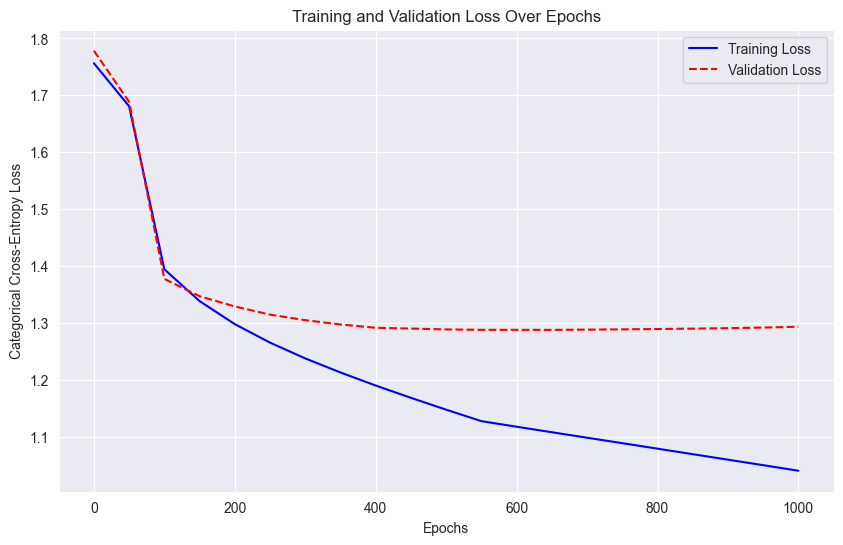


--- Per-Class Accuracy ---
Class 0: 100.00% (94 samples)
Class 1: 0.00% (33 samples)
Class 2: 2.50% (40 samples)
Class 3: 0.00% (35 samples)
Class 4: 0.00% (14 samples)


In [391]:
import matplotlib.pyplot as plt
# import numpy as np # Assumed imported

# 1. SETUP AND TRAINING CALL (Assuming X, Y, and train_val_split are defined)

# You must set these variables for the call:
EPOCHS = 1000  # Example value ###1500 gives accuracy of 0.5 with hidden dim = 10, learning rate = 0.05
LEARNING_RATE = 0.01 # Example value
HIDDEN_DIM = 100 # Example value
HIDDEN_DIM_2 = 50 # Example value
LOG_INTERVAL = 50 # How often to record loss

# Initialize NN (using dimensions from the split data)
INPUT_DIM = X_train_final.shape[0]
OUTPUT_DIM = Y_train_soft.shape[0]

nn = DeepNN(INPUT_DIM, HIDDEN_DIM, HIDDEN_DIM_2,  OUTPUT_DIM)

# Train the model and get the loss histories
train_loss, val_loss = nn.train(
    X_train_final, Y_train_soft,
    X_val_final, Y_val,
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    log_interval=LOG_INTERVAL
)

# 1. Use the length of the actual data returned by the training
actual_length = len(train_loss)

# 2. Generate indices based on that length
# This ensures x and y are always the same size, regardless of EPOCHS settings
epochs_to_plot = np.arange(actual_length) * LOG_INTERVAL

# 3. Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs_to_plot, train_loss, label='Training Loss', color='blue')
plt.plot(epochs_to_plot, val_loss, label='Validation Loss', color='red', linestyle='--')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig('loss_curve.png') # Use this if running in a non-interactive environment

# 5. CHECK PER-CLASS ACCURACY
# This will tell you if we are ignoring Class 4 or not
preds = nn.predict(X_val)
true_labels = np.argmax(Y_val, axis=0)

print("\n--- Per-Class Accuracy ---")
for cls in range(OUTPUT_DIM):
    idx = (true_labels == cls)
    if np.sum(idx) > 0:
        acc = np.mean(preds[idx] == true_labels[idx])
        print(f"Class {cls}: {acc*100:.2f}% ({np.sum(idx)} samples)")

In [392]:
# Predict on Training Set
train_preds = nn.predict(X_train_final)
# Convert Y_train from One-Hot (K, M) to Sparse (M,)
Y_train_sparse = np.argmax(Y_train_soft, axis=0)
train_acc = np.mean(train_preds == Y_train_sparse)

# Predict on Validation Set
val_preds = nn.predict(X_val_final)
# Convert Y_val from One-Hot (K, M) to Sparse (M,)
Y_val_sparse = np.argmax(Y_val, axis=0)
val_acc = np.mean(val_preds == Y_val_sparse)

print(f"Training Accuracy:   {train_acc * 100:.2f}%")
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

Training Accuracy:   59.80%
Validation Accuracy: 46.76%


In [351]:
Y_train

array([[0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], shape=(5, 864))

In [355]:
import pandas as pd

# Convert to Series (if it isn't already) and call value_counts
Y_train_sparse = np.argmax(Y_train, axis=0)
counts = pd.Series(Y_train_sparse).value_counts()

print(counts)

0    392
2    166
3    159
1     95
4     52
Name: count, dtype: int64


In [356]:
import pickle

# Load the pickle file
with open('data/test_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Access images and labels
images_test = data['images']

In [357]:
# 1. Define the weights for R, G, B
rgb_weights = [0.299, 0.587, 0.114]
# This reduces the last dimension from 3 to 1
images_test = np.dot(images_test[..., :3], rgb_weights)



images_test = images_test.reshape(images_test.shape[0], -1)
images_test = images_test / 255.0
X_test = images_test.T  # Shape: (Features, Samples)


In [358]:
test_preds = nn.predict(X_test)
test_preds


array([0, 1, 0, 1, 1, 0, 4, 4, 0, 4, 1, 4, 0, 4, 0, 0, 0, 4, 4, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 4, 0, 1, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 4,
       3, 3, 2, 4, 0, 0, 0, 4, 2, 0, 0, 4, 4, 0, 0, 1, 1, 0, 4, 0, 0, 4,
       0, 1, 1, 4, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 0, 4, 0, 0, 4, 4, 0, 3,
       3, 0, 1, 1, 0, 4, 4, 0, 4, 0, 0, 0, 0, 4, 2, 0, 1, 1, 0, 0, 0, 0,
       3, 1, 0, 1, 0, 0, 4, 4, 4, 0, 1, 4, 0, 0, 0, 4, 4, 3, 2, 0, 0, 4,
       0, 1, 0, 0, 4, 0, 3, 4, 0, 0, 1, 0, 1, 4, 0, 4, 0, 0, 3, 0, 4, 0,
       4, 1, 4, 0, 3, 0, 0, 0, 0, 1, 4, 1, 2, 3, 1, 0, 1, 0, 4, 1, 4, 1,
       0, 1, 4, 0, 0, 1, 0, 0, 0, 4, 0, 4, 1, 4, 3, 3, 0, 0, 4, 0, 4, 4,
       0, 1, 4, 0, 1, 0, 1, 4, 4, 4, 4, 0, 0, 4, 4, 0, 0, 0, 0, 3, 4, 4,
       0, 4, 3, 4, 3, 4, 4, 1, 4, 0, 0, 4, 0, 0, 0, 1, 1, 4, 0, 4, 2, 4,
       0, 0, 0, 2, 0, 4, 1, 1, 4, 2, 3, 1, 0, 0, 1, 0, 0, 1, 3, 3, 4, 1,
       1, 4, 0, 0, 0, 0, 4, 4, 3, 3, 0, 2, 4, 0, 0, 4, 4, 3, 3, 3, 0, 4,
       1, 0, 4, 4, 1, 1, 3, 4, 0, 4, 2, 3, 0, 4, 4,

In [359]:
import pandas as pd
import numpy as np

# 1. Create the DataFrame
submission = pd.DataFrame({
    'ID': range(1, len(test_preds)+1), # Adjust to range(1, ...) if you need 1-based indexing
    'Label': test_preds
})


# 3. Export
submission.to_csv('data/submission.csv', index=False)

print("\n--- Raw File Preview (First 5 lines) ---")
with open('data/submission.csv', 'r') as f:
    for _ in range(5):
        print(f.readline().strip())


--- Raw File Preview (First 5 lines) ---
ID,Label
1,0
2,1
3,0
4,1


## Evaluate Models

Analyze your best model's performance (see README.md for evaluation guidelines).

In [22]:
####################################################################
###############   TO complete   ####################################
####################################################################

## Generate Predictions for Kaggle Submission

Create a CSV file with columns: `id` and `quality` (see README.md for format details).

In [ ]:

####################################################################
###############   TO complete   ####################################
####################################################################

---
Good luck with the competition! 🍺
